**Imports**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


#Get your training and evaluation data

**Datasets and DataLoaders**

In [17]:
import torchvision
import torchvision.transforms as transforms

batch_size = 512

# Define data transformations
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Create DataLoaders for train and test datasets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True,
    persistent_workers=True,
    prefetch_factor = 16
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True,
    persistent_workers=True,
    prefetch_factor = 16
)

print("Num training examples: {}".format(len(train_dataset)))
print("Num test examples: {}".format(len(test_dataset)))


# List of class labels
classes =[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
    ]

Files already downloaded and verified
Files already downloaded and verified
Num training examples: 50000
Num test examples: 10000


**Visualise some of the dataset images**

In [18]:
def vect2image(vector):
  '''
   Conversion format vecteur => format image en couleurs
  '''

  # Reshape the image dimensions to correct order (C, H, W)
  image = vector.reshape((3, 32, 32))
  # Permute dimensions to get the correct order (H, W, C)
  image = torch.permute( image, dims=(1, 2, 0))
  return image

def image2vector(image): #image : (512, 3, 32, 32)
  '''
   Conversion format vecteur => format image en couleurs
  '''
  # Permute dimensions to get the correct order (N, C, H, W)
  image = torch.permute(image, dims=(0, 3, 1, 2))
  # Reshape into a vector
  vect = image.reshape(-1, 3072)
  return vect

torch.Size([512, 3, 32, 32])


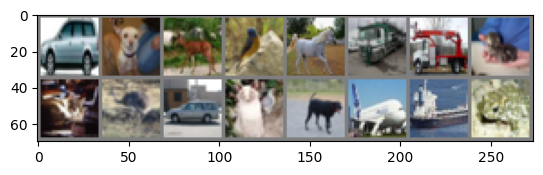

automobile -- dog -- deer -- bird -- horse -- truck -- truck -- cat
cat -- bird -- automobile -- cat -- dog -- airplane -- ship -- frog


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

# Display the images in a grid along with their labels
imshow(torchvision.utils.make_grid(images[:16]))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8)))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8,16)))

#Create a model class

**The torch `nn` module**

In [20]:
class ImageLinearClassifier(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(3072,10)

  def forward(self, x): # x:input  3072 px flattened image
    # Computation Graph Construction ....
    x = image2vector(x) # Convert input image into vector format
    out = self.layer1(x) # # Perform forward pass through the linear layer

    # Apply ReLU activation function to introduce non-linearity
    out = nn.ReLU()(out)
    return out

# Create an instance of the ImageLinearClassifier model
model = ImageLinearClassifier()
# Move the model to the specified device (CPU or GPU)
model.to(device)


ImageLinearClassifier(
  (layer1): Linear(in_features=3072, out_features=10, bias=True)
)

#Perform forward passes with training data

In [21]:
# Print the shapes of the weight and bias parameters of the linear layer
print(model.layer1.weight.shape, model.layer1.bias.shape)

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Check the shape of the labels
print(labels.shape)

# Pass the batch of images through the model
out = model(images)  # Same as calling model.forward(images)
print(out)  # Print the output
print(out.shape)  # Print the shape of the output tensor


torch.Size([10, 3072]) torch.Size([10])
torch.Size([512])
tensor([[0.0707, 0.0000, 0.1696,  ..., 0.1435, 0.0000, 0.1829],
        [0.0368, 0.0000, 0.2243,  ..., 0.2410, 0.3977, 0.2194],
        [0.0879, 0.0000, 0.1708,  ..., 0.0190, 0.0000, 0.0506],
        ...,
        [0.0000, 0.0000, 0.5813,  ..., 0.0000, 0.0720, 0.4967],
        [0.1611, 0.0000, 0.0000,  ..., 0.3016, 0.1915, 0.0000],
        [0.0000, 0.0000, 0.1503,  ..., 0.0000, 0.2603, 0.0000]],
       grad_fn=<ReluBackward0>)
torch.Size([512, 10])


#Set up an optimizer

Let's add a simple loss function

In [24]:
# Define the CrossEntropyLoss criterion
criterion = nn.CrossEntropyLoss()

# Compute the loss between the model predictions (out) and the ground truth labels (labels)
loss = criterion(out, labels)

# Print the computed loss
print(loss)


tensor(2.3024, grad_fn=<NllLossBackward0>)


In [25]:
# Initialize an Adam optimizer with a learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Clear the gradients of all optimized parameters
optimizer.zero_grad()

# Perform backpropagation to compute the gradients of the loss with respect to model parameters
loss.backward()

# Print the gradients of the model parameters (weights and biases of layer1)
print(model.layer1.weight.grad, model.layer1.bias.grad)


tensor([[-0.0034, -0.0045, -0.0045,  ..., -0.0204, -0.0200, -0.0186],
        [-0.0029, -0.0044, -0.0045,  ..., -0.0017, -0.0005, -0.0009],
        [ 0.0086,  0.0079,  0.0055,  ...,  0.0054,  0.0057,  0.0083],
        ...,
        [-0.0088, -0.0056, -0.0061,  ...,  0.0053,  0.0039,  0.0024],
        [ 0.0083,  0.0089,  0.0092,  ...,  0.0025,  0.0020,  0.0027],
        [ 0.0003,  0.0003,  0.0007,  ...,  0.0045,  0.0044,  0.0012]]) tensor([-0.0067, -0.0054,  0.0180,  0.0123,  0.0077, -0.0027, -0.0149, -0.0094,
         0.0053,  0.0105])


In [28]:
# Update the parameters of the model based on the computed gradients
optimizer.step()

**A general PyTorch recipe:**


1.   Get your training and evaluation data
2.   Create a model class
3.   Set up an optimizer
4.   Perform forward passes with training data
5. `optimizer.zero_grad()`
6. `loss.backward()`
7. `optimizer.step()`
8. After few steps of training, evaluate on evaluation data
9. Repeat until loss doesn't decrease or evaluation performance starts to fall off



#Train Loop : Regroupe toutes ces etapes

In [29]:
import tqdm

num_epochs = 10
for epoch in range(num_epochs):
  running_loss = 0.0

  # Iterate over the batches in the train_loader
  for i, (images, labels) in enumerate(tqdm.tqdm(train_loader, bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}'), 0):

      # Move the batch to the device (GPU if available)
      images = images.to(device, non_blocking=True)
      labels = labels.to(device, non_blocking=True)

      # Zero the gradients
      optimizer.zero_grad()

      # Forward pass: compute predicted outputs by passing inputs to the model
      out = model(images)

      # Compute the loss
      loss = criterion(out, labels)

      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # Perform a single optimization step (parameter update)
      optimizer.step()

      # Update the running loss
      running_loss += loss.item()
    # Calculate and print the average loss for this epoch
  avg_loss = running_loss / (i + 1)
  print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


100%|██████████████████████████████| 98/98 [00:12<00:00,  8.01it/s]


Epoch [1/10], Loss: 1.8377


100%|██████████████████████████████| 98/98 [00:11<00:00,  8.74it/s]


Epoch [2/10], Loss: 1.7466


100%|██████████████████████████████| 98/98 [00:11<00:00,  8.84it/s]


Epoch [3/10], Loss: 1.7219


100%|██████████████████████████████| 98/98 [00:11<00:00,  8.50it/s]


Epoch [4/10], Loss: 1.7062


100%|██████████████████████████████| 98/98 [00:12<00:00,  8.05it/s]


Epoch [5/10], Loss: 1.6979


100%|██████████████████████████████| 98/98 [00:11<00:00,  8.63it/s]


Epoch [6/10], Loss: 1.6863


100%|██████████████████████████████| 98/98 [00:11<00:00,  8.66it/s]


Epoch [7/10], Loss: 1.6774


100%|██████████████████████████████| 98/98 [00:13<00:00,  7.52it/s]


Epoch [8/10], Loss: 1.6694


100%|██████████████████████████████| 98/98 [00:11<00:00,  8.19it/s]


Epoch [9/10], Loss: 1.6683


100%|██████████████████████████████| 98/98 [00:11<00:00,  8.30it/s]

Epoch [10/10], Loss: 1.6612


torch.Size([3072])
torch.Size([32, 32, 3])


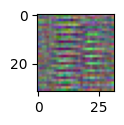

In [32]:
# Get the parameters (weights and biases) of the model
W = list(model.parameters())

# Extract the weight tensor of the first linear layer (index 0)
W = W[0]

# Extract a specific row from the weight tensor (index 7)
W = W[7]

# Print the shape of the extracted tensor
print(W.shape)

# Convert the tensor to an image using the vect2image function
W_image = vect2image(W)

# Print the shape of the converted image tensor
print(W_image.shape)

# Normalize the image tensor to range [0, 1]
W_image = (W_image - W_image.min()) / (W_image.max() - W_image.min())

# Plot the image
plt.figure(figsize=(1., 1.))
plt.imshow(W_image.cpu().detach())
plt.show()


**Saving and loading models**

In [33]:
# Get the state dictionary of the model
state_dict = model.state_dict()

# Print the state dictionary
print(state_dict)

OrderedDict([('layer1.weight', tensor([[ 0.0340,  0.0089, -0.0218,  ..., -0.0411, -0.0246, -0.0352],
        [-0.0204, -0.0115, -0.0226,  ...,  0.0124,  0.0034,  0.0066],
        [-0.0170, -0.0332,  0.0067,  ..., -0.0276, -0.0594, -0.0554],
        ...,
        [-0.0065, -0.0512, -0.0004,  ..., -0.0181, -0.0437, -0.0446],
        [ 0.0553,  0.0313,  0.0088,  ...,  0.0519,  0.0887,  0.0801],
        [-0.0245, -0.0346, -0.0155,  ..., -0.0115, -0.0093,  0.0260]])), ('layer1.bias', tensor([ 0.3009, -0.0590,  0.3143,  0.4288, -0.0093,  0.2425, -0.0868, -0.0564,
         0.1566, -0.2216]))])


In [34]:
# Save the state dictionary to a file
torch.save(state_dict, "model.pt") # saving the model


In [35]:
# Create an instance of the model
model = ImageLinearClassifier()

# Load the state dictionary from the file
state_dict = torch.load("model.pt")

# Load the state dictionary into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

A couple more useful torch modules that you might find useful for assignments 2 and 3 are `nn.Sequential` and the `Conv2D` module. Check these out in the [PyTorch documentation](https://pytorch.org/docs/stable/index.html)!

#Evaluer sur le Test Dataset

In [36]:
# Initialize empty lists to store ground truth labels and model predictions
all_labels = []
all_predictions = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation since no backpropagation is needed during inference
with torch.no_grad():
    # Iterate over the batches in the test_loader
  for i, (images, labels) in enumerate(test_loader, 0):
    # Move the batch to the specified device (GPU if available)
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)

    # Append the ground truth labels to the all_labels list
    all_labels.append(labels)

    # Forward pass: compute predicted outputs by passing inputs to the model
    out = model(images)

    # Compute model predictions (class with highest probability)
    predictions = torch.argmax(out, dim=1)

    # Append the model predictions to the all_predictions list
    all_predictions.append(predictions)


In [37]:
# Concatenate the list of ground truth labels into a single tensor
all_labels = torch.cat(all_labels)

# Concatenate the list of model predictions into a single tensor
all_predictions = torch.cat(all_predictions)

In [38]:
# Create a mask where elements are True if the ground truth label matches the model prediction, False otherwise
msk = all_labels == all_predictions

# Calculate the accuracy by dividing the number of correct predictions by the total number of predictions
accuracy = torch.sum(msk).item() / all_labels.shape[0]

# Print the accuracy
print(f"Accuracy: {accuracy}")

Accuracy: 0.4076
